<a href="https://colab.research.google.com/github/Trip1ewhy/Duke_xAI_Wayne/blob/main/Assignment_05_Wayne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #05
### Explainable Techniques

Instructions
Generate local explanations for individual predictions from a pre-trained blackbox model (ie ResNet34, Inception, BERT, YOLO, GPT-2). You may use LIME, SHAP, or Anchors for this assignment. At least one visualization of your explanation is required.



Include a discussion that explains why you chose the explanation technique you did. In this discussion, include strengths, limitations, and potential improvements to your approach. t your fellow students would be able to understand the algorithm visually.


### Wayne Yang
#### https://github.com/Trip1ewhy/Duke_xAI_Wayne/blob/main/Assignment_05_Wayne.ipynb

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1QDUfUw5Qc-ToWoOmDOveGh3JXxRv_ISh#scrollTo=P9ZERjG3PqyA)

In [1]:
!rm -r ./sample_data

rm: cannot remove './sample_data': No such file or directory


In [2]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data


# Clone GitHub files to colab workspace
repo_name = "Duke_xAI_Wayne" # Change to your repo name
git_path = 'https://github.com/Trip1ewhy/Duke_xAI_Wayne.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'Assignment #05_Wayne'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

fatal: destination path 'Duke_xAI_Wayne' already exists and is not an empty directory.
[Errno 2] No such file or directory: 'Duke_xAI_Wayne/Assignment #05_Wayne'
/content
Duke_xAI_Wayne/


In [3]:
pip install lime

In [4]:
pip install shap

In [5]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from lime.lime_text import LimeTextExplainer
from scipy.special import softmax
import torch
import shap
import numpy as np
import matplotlib.pyplot as plt



In [19]:
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set pad_token_id to eos_token_id to avoid the warning
tokenizer.pad_token = tokenizer.eos_token

# Function to generate text with attention mask
def generate_text(prompt, max_length=100, temperature=0.7):
    # Encode the input prompt and set the attention mask
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    #attention_mask = input_ids.ne(tokenizer.pad_token_id).long()  # Create attention mask

    # Generate text
    output = model.generate(
        input_ids,
        #attention_mask=attention_mask,  # Pass the attention mask
        max_length=max_length,
        temperature=temperature,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        do_sample=True,
        top_p=0.1, #set relatively low top-p
        pad_token_id=tokenizer.pad_token_id  # Set pad token ID to avoid warnings
    )

    # Decode the generated text and return it
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

In [7]:

# Generate Prompt
prompt = "I was late for work this morning because my alarm didn't go off. When I finally got out of bed, I realized I had also forgotten to"
generated_text = generate_text(prompt, max_length=50, temperature=0.1) # low temperature
print(generated_text)


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


I was late for work this morning because my alarm didn't go off. When I finally got out of bed, I realized I had also forgotten to turn off my phone. I was so confused.

"I'm sorry, but I'm


## LIME ##

In [8]:
def LIME_gpt2_content(texts):
    # tokenize
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)

    # get model's output
    outputs = model(**inputs)

    # choose logits
    logits = outputs.logits[:, -1, :]  # 只取最后一个token的输出

    # softmax to make it probability
    probabilities = torch.softmax(logits, dim=-1).detach().numpy()

    return probabilities

30


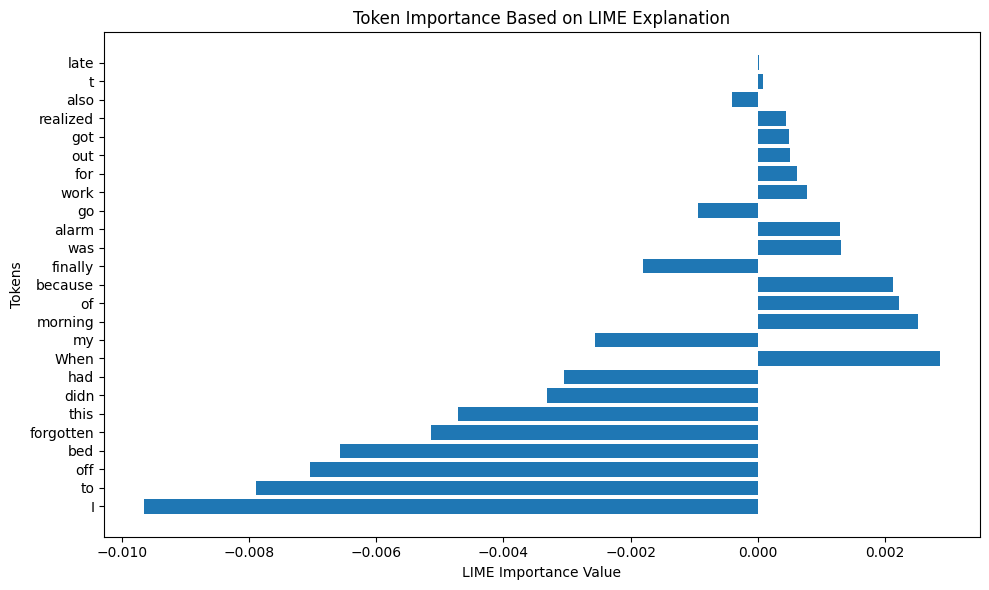

In [9]:
# LIME Text Explainer
explainer = LimeTextExplainer()

# Example prompt for testing
prompt = "I was late for work this morning because my alarm didn't go off. When I finally got out of bed, I realized I had also forgotten to"

tokenized_input = tokenizer.tokenize(prompt)
num_tokens = len(tokenized_input)
print(num_tokens)
# Explain GPT-2 prediction with LIME
exp = explainer.explain_instance(prompt, LIME_gpt2_content, num_features=num_tokens, num_samples=250) #higher num_samples may crash

# Extract the words (tokens) and their corresponding importance from the LIME explanation
lime_tokens = [word for word, weight in exp.as_list()]
lime_values = [weight for word, weight in exp.as_list()]

# Create a horizontal bar chart to display the importance of each token

plt.figure(figsize=(10, 6))
plt.barh(lime_tokens, lime_values)
plt.xlabel('LIME Importance Value')
plt.ylabel('Tokens')
plt.title('Token Importance Based on LIME Explanation')
plt.tight_layout()
plt.show()


1. Y-axis: Tokens
The Y-axis lists individual tokens (words or subwords) from the input text, such as "I", "forgotten", "this", "bed", etc. These tokens represent the specific pieces of text that GPT-2 received as input to generate its output.
2. X-axis: LIME Importance Value
The X-axis shows the LIME importance value for each token. This value indicates how much each token influenced GPT-2’s prediction.
Positive values suggest that the token contributed positively to the model's output, while negative values suggest the token had a suppressing or negative impact on the output. The larger the absolute value, the greater the influence the token had on the result.
3. Token Importance
In this chart, tokens with higher absolute values have a greater influence on GPT-2’s output:

"I" shows a significant negative importance, meaning this token likely reduced the probability of certain outputs in the prediction.

"forgotten" and "bed" also have strong negative contributions, indicating they negatively impacted the model's output, pushing it away from certain predictions.

Tokens like "morning" and "finally" have near-zero importance, meaning they had little to no impact on the final prediction.

In [10]:
exp.show_in_notebook(text=True)

In [27]:
token_ids = [1210, 1234, 2222, 1011]

# Decode the token IDs into tokens
tokens = tokenizer.decode(token_ids)

# Print the corresponding tokens
print(tokens)

 turn put bring take


So the most likely next output is "turn", "put", "bring" and "take"


The model made its prediction based on the importance of individual words. The words "I," "forgotten," "bed," and "off" had the greatest impact on the output, with some tokens having minimal or no effect.



###why:

LIME doesn’t require access to the internal architecture or parameters of GPT-2. It works by treating GPT-2 as a black-box model. LIME perturbs the input text and observes how GPT-2's predictions change. This allows LIME to assign importance to individual input tokens based on how much they affect the model’s output.


###strengths:
1. LIME is flexible and can be applied to various data types, including tabular data, text, and images. This makes it a versatile tool that can be used across many different domains, from natural language processing (NLP) to image classification, without needing specialized modifications for different types of data.

2. LIME approximates complex models locally with simpler interpretable models, often using linear models for these local approximations.

3. LIME’s process is easy to understand: it perturbs the input and observes the effect on the model’s output. This simplicity makes LIME intuitive for users who may not have extensive knowledge of machine learning or model internals.


###limitations:
1. LIME can be computationally expensive and slow, especially for complex models like deep learning models. Since LIME generates explanations by perturbing the input and observing how the model's predictions change, the process requires the model to be queried multiple times

2. The way LIME perturbs the input data and defines the local neighborhood is crucial to the quality of the explanations. However, there is no clear guideline on how to choose the right perturbation strategy or the size of the neighborhood, which can affect the reliability of the explanations.

3. For tasks involving text or images, LIME's performance can be highly sensitive to how input features (words or pixels) are represented. The quality of the explanation can vary depending on how the text is tokenized

###potential improvements:
GPT series generates probabilistic outputs, and one token may be part of several possible continuations. Instead of explaining only one generated output, I can explain multiple generated sequences and aggregate the results to better understand how certain tokens affect different potential outputs.

##SHAP

In [21]:
# Function to generate GPT-2 logits for a batch of inputs
def SHAP_gpt2_predict(inputs):
    with torch.no_grad():
        outputs = model(torch.tensor(inputs))

    # get last token's logits and get softmax probability distribution
    next_token_logits = outputs.logits[:, -1, :]
    probs = torch.softmax(next_token_logits, dim=-1).detach().numpy()

    return probs

In [24]:
# use a background input
#model.to(device)
background_text = ["I ended up missing the bus because I lost track of time."]
background_inputs = tokenizer(background_text, return_tensors="pt")['input_ids'].numpy()

# define SHAP explainer
explainer = shap.KernelExplainer(SHAP_gpt2_predict, background_inputs)

encoded_input = tokenizer(prompt, return_tensors="pt")['input_ids'].numpy()

# calculate SHAP value
shap_values = explainer.shap_values(encoded_input)


print(shap_values)

# Get SHAP values for the GPT-2 prediction based on the tokenized prompt


  0%|          | 0/1 [00:00<?, ?it/s]

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.81375774e-05  1.81837725e-05 -6.11854493e-06 ...  4.60241883e-09
    2.76326816e-09 -1.33479732e-03]
  [ 4.91554201e-05 -3.77280248e-06  6.68663678e-06 ... -2.59989206e-10
    2.14248446e-09  4.81145023e-05]
  ...
  [-4.98451895e-04 -2.92183223e-04 -1.72707761e-05 ... -2.80700709e-08
   -3.98856738e-08  2.30017916e-04]
  [ 3.39943897e-04  1.06540901e-04  4.95541438e-05 ...  4.76058188e-09
    1.66780179e-08 -6.15152185e-05]
  [ 8.50131917e-04  3.42165662e-04 -3.35467631e-05 ...  4.37191399e-08
    5.79765459e-09 -3.75431202e-03]]]


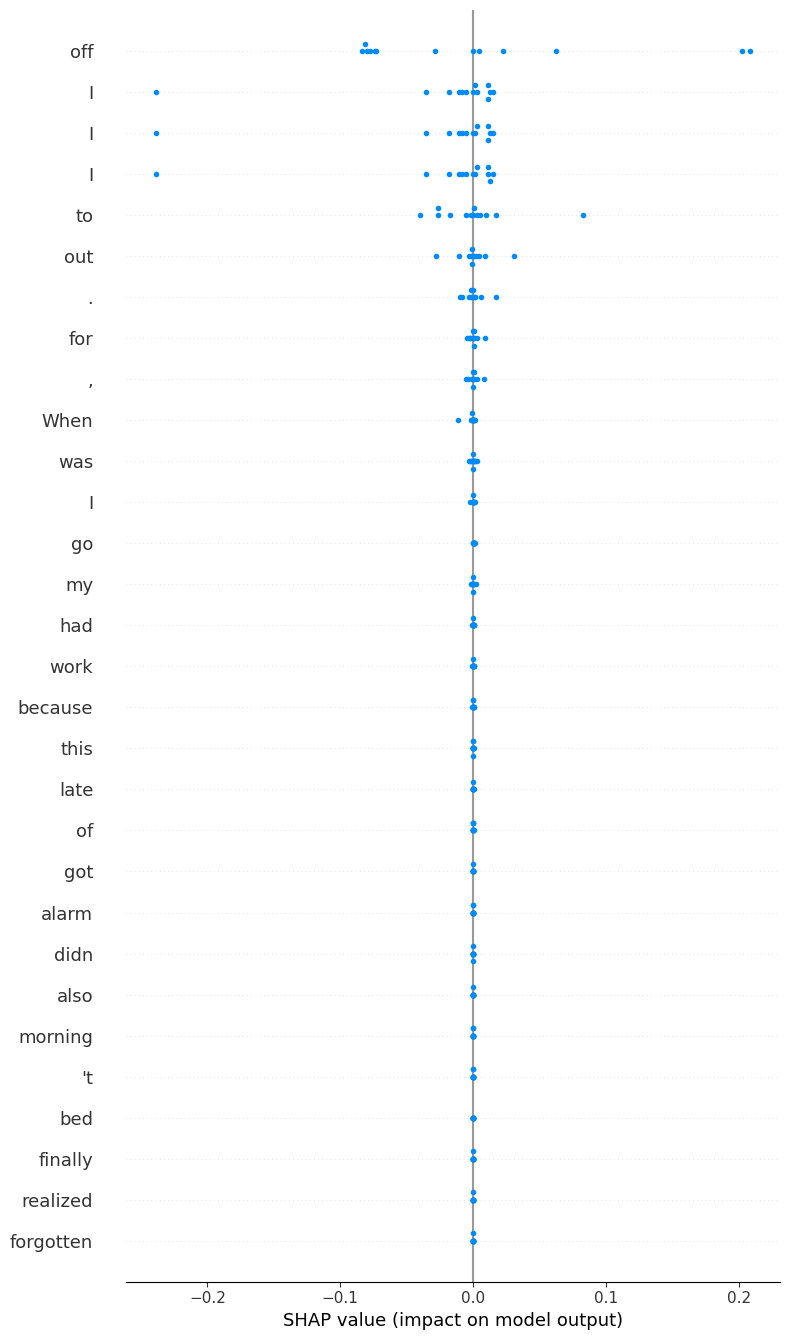

In [25]:
#print(f"Shape of shap_values: {shap_values.shape}")
#print(f"Shape of encoded_input: {encoded_input.shape}")

shap_values_for_tokens = shap_values[0][:, encoded_input[0]]  # 提取每个 token 对应的 SHAP 值

# check whether shapes are matched
#print(f"Shape of shap_values_for_tokens: {shap_values_for_tokens.shape}")  # 形状应为 (num_tokens, num_tokens)

# decode, convert to token
tokens = tokenizer.convert_ids_to_tokens(encoded_input[0])
# 去除 token 中的 "Ġ"
clean_tokens = [token.replace('Ġ', '') for token in tokens]
#print(f"Shape of shap_values_for_tokens: {encoded_input[0].shape}")  # 形状应为 (num_tokens, num_tokens)



# 可视化 SHAP 值
shap.summary_plot(shap_values_for_tokens, features=clean_tokens,max_display=len(clean_tokens))

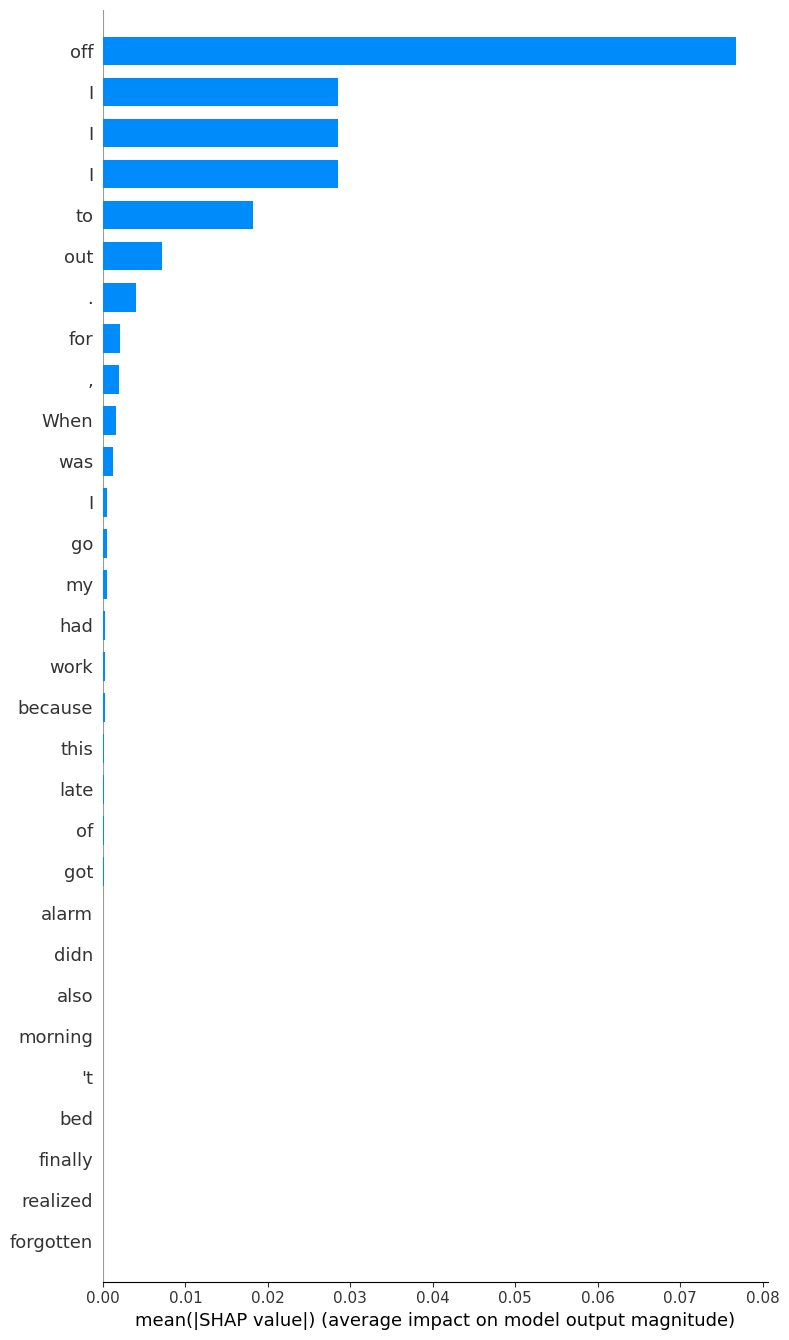

In [26]:
shap.summary_plot(shap_values_for_tokens, features = clean_tokens, plot_type="bar",max_display=len(clean_tokens))